# 04 .Pytorch Custom datasets

## 0. Importing and Device Agnostic'




In [ ]:
import torch
from torch import nn

In [ ]:
# setup device agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get Data

Our datset is a subset of the food 101 dataset

Food101 starts 101 different classes of food and 1000 images per class(750 training,250 testing)

our dataset starts with 3 classes of food and only 10% of the images

In [ ]:
import requests
import zipfile
from pathlib import Path

# setup path data loader
data_path = Path("/data")
image_path = data_path / "pizza_steak_sushi"

#if the image path folder doesn't exist,download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} is alreay exist")
else:
  print(f"creating{image_path} doesn't exist,creating one...")
  image_path.mkdir(parents=True,exist_ok=True)

# Download
with open (data_path / "pizza_steak_sushi.zip","wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza,steak , sushi data")
  f.write(request.content)

# unzip pizza ,steak,sushi data
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip","r") as zip_ref:
  print("unzipping pizza_steak_sushi data")
  zip_ref.extractall(image_path)

/data/pizza_steak_sushi is alreay exist
unzipping pizza_steak_sushi data


## 2. Becoming with data (data preparation and exploration)


In [ ]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath,dirnames,filenames in os.walk(dir_path):
    print(f"there are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [ ]:
walk_through_dir(image_path)

there are 2 directories and 0 images in '/data/pizza_steak_sushi'
there are 3 directories and 0 images in '/data/pizza_steak_sushi/train'
there are 0 directories and 78 images in '/data/pizza_steak_sushi/train/pizza'
there are 0 directories and 75 images in '/data/pizza_steak_sushi/train/steak'
there are 0 directories and 72 images in '/data/pizza_steak_sushi/train/sushi'
there are 3 directories and 0 images in '/data/pizza_steak_sushi/test'
there are 0 directories and 25 images in '/data/pizza_steak_sushi/test/pizza'
there are 0 directories and 19 images in '/data/pizza_steak_sushi/test/steak'
there are 0 directories and 31 images in '/data/pizza_steak_sushi/test/sushi'


In [ ]:
# setup training and test paths
train_dir = image_path /"train"
test_dir = image_path/"test"

train_dir,test_dir

(PosixPath('/data/pizza_steak_sushi/train'),
 PosixPath('/data/pizza_steak_sushi/test'))

## 2.1 Visualing a image

1. get all of the image paths
2. Pick a  random image path using Python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. since we're working with images,Let's open the image with python's PIL
5. We'll then show the image and print metadata

random image path:/data/pizza_steak_sushi/train/pizza/3338774.jpg
image class:pizza
image height:289
image width: 512


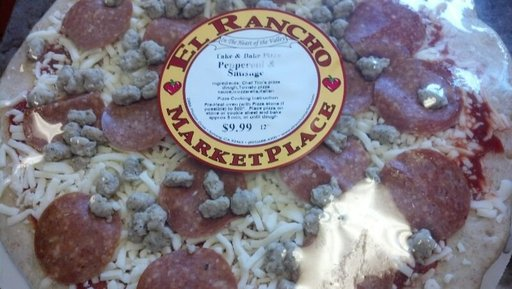

In [ ]:
import random
from PIL import Image

#Set seed
# random.seed(42)

# 1 get all image path
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2.pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
# image_class

# 4 Open image
img = Image.open(random_image_path)

# 5 print metadata
print(f"random image path:{random_image_path}")
print(f"image class:{image_class}")
print(f"image height:{img.height}")
print(f"image width: {img.width}")
img

(np.float64(-0.5), np.float64(511.5), np.float64(288.5), np.float64(-0.5))

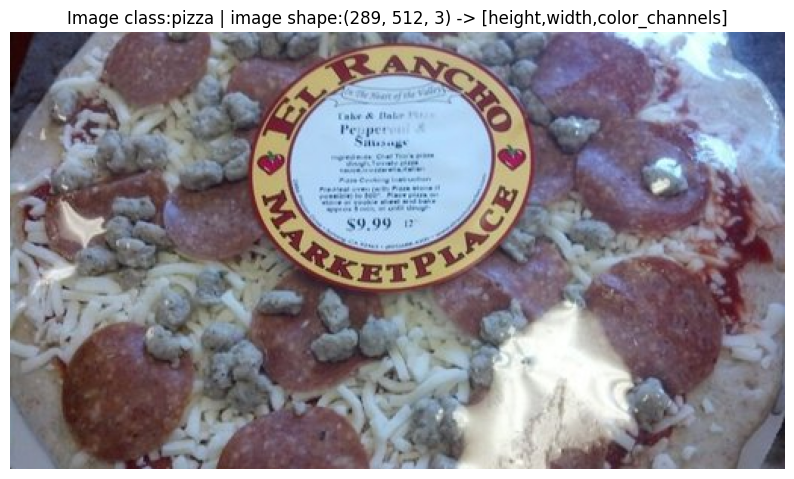

In [ ]:
# visualize with matplot lib
import numpy as np
import matplotlib.pyplot as plt

# Turn the image in the array
img_as_array = np.asarray(img)

# plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class:{image_class} | image shape:{img_as_array.shape} -> [height,width,color_channels]")
plt.axis(False)

array([[[ 25,   6,   2],
        [ 27,   8,   4],
        [ 32,   8,   6],
        ...,
        [ 46,  58,  98],
        [ 49,  58,  99],
        [ 48,  57,  98]],

       [[ 25,   6,   2],
        [ 28,   7,   4],
        [ 33,   9,   7],
        ...,
        [ 50,  62, 102],
        [ 50,  59, 100],
        [ 47,  56,  97]],

       [[ 26,   7,   3],
        [ 29,   8,   5],
        [ 33,   9,   7],
        ...,
        [ 50,  62, 102],
        [ 48,  57,  98],
        [ 44,  53,  94]],

       ...,

       [[123, 132, 149],
        [126, 135, 152],
        [129, 138, 155],
        ...,
        [ 64,  58,  68],
        [ 66,  58,  69],
        [ 67,  59,  70]],

       [[119, 126, 142],
        [122, 131, 146],
        [127, 136, 153],
        ...,
        [ 66,  63,  74],
        [ 66,  60,  72],
        [ 65,  59,  71]],

       [[ 79,  86,  96],
        [121, 129, 140],
        [130, 137, 153],
        ...,
        [ 71,  69,  82],
        [ 73,  69,  83],
        [ 67,  63,  77]]], dtype=uint8)
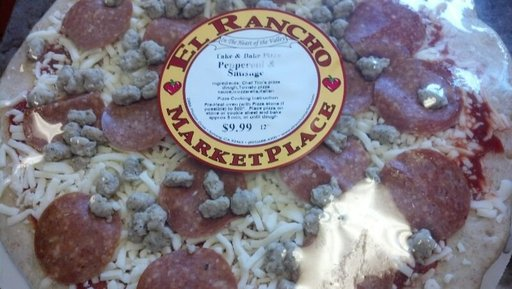

In [ ]:
img_as_array

## 3. Tranforming data

Before we can use our data image data with Pytorch

1. turn your target data into tensors

2. Turn it into a `torch.utils.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets,transforms

### 3.1 Tranforming data with `torchvision.transforms`

In [ ]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our image to (64X64)
    transforms.Resize(size=(64,64)),
    # filp the images random on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.tensor
    transforms.ToTensor()
])

In [ ]:
data_transform(img)

tensor([[[0.1412, 0.1529, 0.2039,  ..., 0.2157, 0.2078, 0.1961],
         [0.1451, 0.1608, 0.2196,  ..., 0.2118, 0.2039, 0.2118],
         [0.1490, 0.1843, 0.2314,  ..., 0.2431, 0.2196, 0.2353],
         ...,
         [0.5098, 0.5216, 0.4902,  ..., 0.4627, 0.3725, 0.2039],
         [0.5098, 0.5216, 0.5098,  ..., 0.4549, 0.3059, 0.1922],
         [0.5059, 0.5216, 0.5176,  ..., 0.4471, 0.3255, 0.2510]],

        [[0.0235, 0.0510, 0.1961,  ..., 0.2980, 0.2784, 0.2510],
         [0.0275, 0.0824, 0.2196,  ..., 0.2941, 0.2745, 0.2667],
         [0.0235, 0.1216, 0.2392,  ..., 0.3216, 0.2902, 0.2902],
         ...,
         [0.5412, 0.5451, 0.5137,  ..., 0.4745, 0.3804, 0.2000],
         [0.5412, 0.5451, 0.5373,  ..., 0.4706, 0.3137, 0.1804],
         [0.5373, 0.5451, 0.5490,  ..., 0.4627, 0.3294, 0.2353]],

        [[0.0235, 0.0745, 0.2588,  ..., 0.4941, 0.4510, 0.4118],
         [0.0235, 0.1137, 0.3059,  ..., 0.4941, 0.4510, 0.4314],
         [0.0275, 0.1647, 0.3294,  ..., 0.5255, 0.4706, 0.

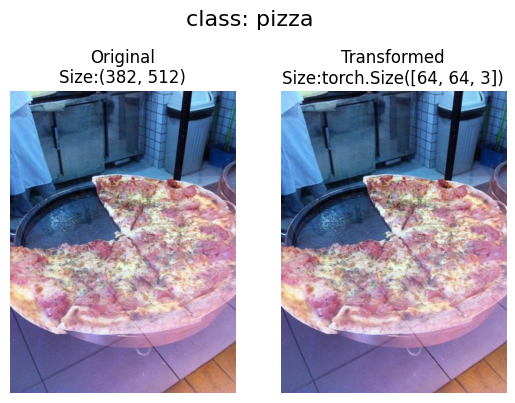

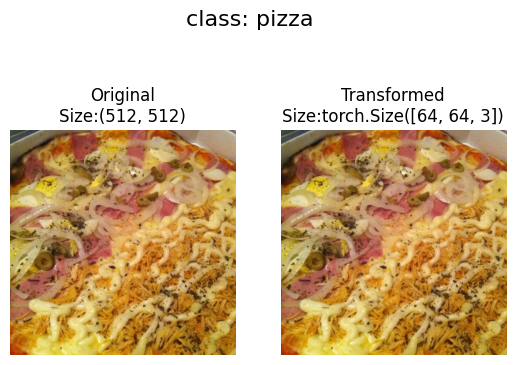

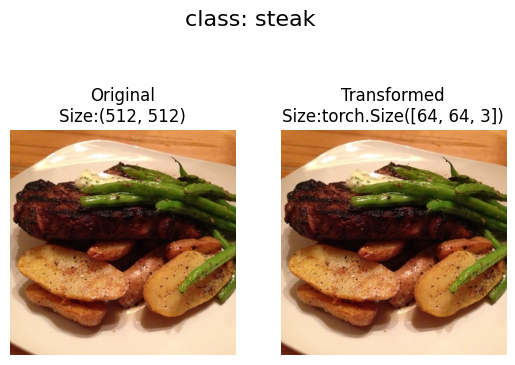

In [ ]:
def plot_transformed_images(image_path,transform,n=3,seed=42):
  """
  Selects random images and from a path of images and loads/transforms
  them and plots the original vs the transformed version
  """

  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_path,k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig,ax = plt.subplots(nrows=1,ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize:{f.size}")
      ax[0].axis(False)
      # transform and plot target image
      tranformed_image = transform(f).permute(1,2,0) # note we will need to change shape for matplotlib (c,h,w) -> (h,w,c)
      ax[1].imshow(f)
      ax[1].set_title(f"Transformed\nSize:{tranformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"class: {image_path.parent.stem}",fontsize=16)

plot_transformed_images(image_path=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

## 4. option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`

In [ ]:
# Use the ImageFolder to create datasets
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a Transform for the label/target
test_data = datasets.ImageFolder(root=test_dir,
                                transform=data_transform)
train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: /data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: /data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
# get class names
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
# get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# check the lenth of the dataset
len(train_data),len(test_data)

(225, 75)

In [ ]:
# index on the train_data dataset to get a single image and label
img,label = train_data[0][0],train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"image shape:{img.shape}")
print(f"Image Dataype:{img.dtype}")
print(f"label:{label}")
print(f"Label datatype:{type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Original shape:torch.Size([3, 64, 64])
Image permute (image):torch.Size([64, 64, 3])


/tmp/ipython-input-980522794.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img)


Text(0.5, 1.0, 'pizza')

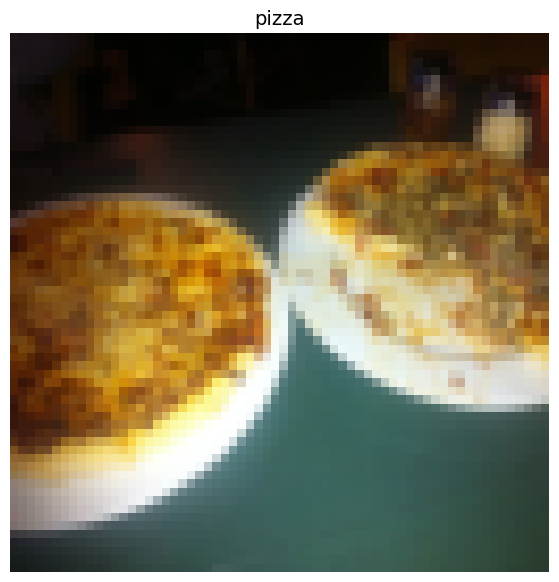

In [ ]:
# rearrang the order of dimension
img = torch.tensor(img)
permute = img.permute(1,2,0)

# print out different shapes
print(f"Original shape:{img.shape}")
print(f"Image permute (image):{permute.shape}")

#Plot the image
plt.figure(figsize=(10,7))
# Convert the image tensor to uint8 and scale to [0, 255]
plt.imshow(permute)
plt.axis("off")
plt.title(class_names[label],fontsize=14)

## 4.1 Turn loaded images into `DataLoader`

A `DataLoader` is going to help us turn our `Dataset` into iterable and we can customize the batch size so our model can see `batch-size` images at a time

In [ ]:
# Turn train and test datasets into dataloaders
from torch.utils.data import DataLoader
BATCH_SIZE=32
train_dataloader = DataLoader(dataset = train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(), # This is a give no of cpu count
                              shuffle=True)
test_dataloader = DataLoader(dataset = test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a5b4d1d8a40>,
 <torch.utils.data.dataloader.DataLoader at 0x7a5b4d00e4e0>)

In [ ]:
len(train_dataloader),len(test_dataloader)

(8, 3)

In [ ]:
img,label=next(iter(train_dataloader))

# Batch size will now be 1 ,you can change the batch size if you like
print(f"Image shape:{img.shape}")
print(f"label shape:{label.shape}")

Image shape:torch.Size([32, 3, 64, 64])
label shape:torch.Size([32])


## 5 Option 2: Loading Image data with a custom `Dataset`
 1. Want to be able to load images from file
 2. Want to be able to get class names from the datasets
 3. Want to be able to get classes as dictionary from the Dataset

Pros:
* can create a `Dataset` out of almost anything
* Not limited to pytorch pre-build `Dataset` funtions

cons:
* Even though you could create `Dataset` out of almost anything, it doesn't mean it will work...
* Using a custom `Dataset` often results in us writing more code,which could be prone to errors or performance issues

In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple,Dict,List

### 5.1 Creating a helper functions to get class names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally) the directory is in standard image classification format
2. raise and error if the class name are't found (if this happends,there might be something wrong with the directory structure)
3. Turn the class names into a dict and a list and return them


In [ ]:
target_dir = train_dir
print(f"Target dir {target_dir}")

# get class names
class_name_found = sorted([entry.name for entry in list(os.scandir(target_dir))])
class_name_found

Target dir /data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [ ]:
def find_classes(directory:str) -> Tuple[List[str],Dict[str,int]]:
  """Find the classes folder name in the target dir"""
  # 1.get class name
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  #2 raise an error if class names is not found
  if not classes:
    raise FileNotFoundError(f"couldn't find any classes in {directory}... please check file structure")

  # 3 Create a dictionary of index labels (computer perfer number )
  class_to_idx = {class_name:i for i,class_name in enumerate(classes)}
  return classes,class_to_idx

In [ ]:
find_classes(target_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset,we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclasses with target dir as well as transform if we'd like to transform our data
3. create several attributes:
  * paths - path of our images
  * transform - the transform we'd like to use
  * classes - a list of the target classes
  * class_to_idx - a dict of the target classes mapped to integer labels
4.  create a function to `load_images()` , this function will open an image
5. Overwrite the `__len()__` method to return the length od our dataset
6. Overwrite the `__getitem()`method to return a given sample when passed index

In [ ]:
# write a custom datasets class
from torch.utils.data import Dataset

# 1.subclass
class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self,
               tar_dir:str,
               transform=None):
    # 3 create class attributes
    # get all of the image paths
    self.paths = list(pathlib.Path(tar_dir).glob("*/*.jpg"))

    # setup tranform
    self.transform = transform

    # create classes and class_to_idx attributes
    self.classes,self.class_to_idx= find_classes(tar_dir)

  # 4.create a function to load images
  def load_image(self,index:int) -> Image.Image:
    """Opens an image via a path and returns it."""
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite _-len__()
  def __len__(self) -> int:
    "return the total number of samples."
    return len(self.paths)

  # 6. Overwrite __getitem()__ method to return a particular sample
  def __getitem__(self,index:int) -> Tuple[torch.Tensor,int]:
    "returns one sample of data ,data and label(x,y)"
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in formate: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if neccessary
    if self.transform:
      return self.transform(img),class_idx  # return data label(x,y)
    else:
      return img,class_idx # return untransformed image and label

In [ ]:
# create a transform
from torchvision import transforms
train_transforms = transforms.Compose([
                                          transforms.Resize(size=(64,64)),
                                          transforms.RandomHorizontalFlip(p=0.5),
                                          transforms.ToTensor()
])
test_transforms = transforms.Compose([
                                          transforms.Resize(size=(64,64)),
                                          transforms.ToTensor()
])

In [ ]:
# test our ImageFolderCustom
train_data_custom = ImageFolderCustom(tar_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(tar_dir = test_dir,
                                     transform=test_transforms)

In [ ]:
train_data_custom,test_data_custom

(<__main__.ImageFolderCustom at 0x7a5ab8a49640>,
 <__main__.ImageFolderCustom at 0x7a5ab8a332c0>)

In [ ]:
len(train_data),len(train_data_custom)

(225, 225)

In [ ]:
len(test_data),len(test_data_custom)

(75, 75)

In [ ]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [ ]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

### 5.3 Create a function to display random images

1. take in a `Dataset` and a number of other parameters such as class names and how many images to visualize
2. To prevent the display getting out hand, let's cap the number of images to see at 10
3. random seed for reproducibility
4. Get a list of random samples indexes from the target dataset.
5. Setup matplotlib plot
6. Loop through the random sample images and plot them with matplotlib
7. Make sure the dimensions of our images line up with matplotlib

In [ ]:
# 1 create a function to take a dataset
def display_random_images(dataset:torch.utils.data.Dataset,
                          classes:List[str]=None,
                          n:int=10,
                          display_shape:bool=True,
                          seed:int=None):
  # 2. Adjust display if n is too high
  if n>10:
    n = 10
    display_shape = False
    print(f"for display,purpose ,n shouldn't be larger then 10 ,setting to 10 and removing shape display")

  # 3. set the random seed
  if seed:
    random.seed(seed)
  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)),k=n)

  # 5 setup plot
  plt.figure(figsize=(16,8))

  # 6. Loop through random o=indexes and plot them withmatplot lib
  for i , targ_sample in enumerate(random_samples_idx):
    targ_image,targ_label = dataset[targ_sample][0],dataset[targ_sample][1]

    # 7. adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1,2,0)

    # plot adjusted samples
    plt.subplot(1,n,i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"classes:{classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape:{targ_image_adjust.shape}"
    plt.title(title)

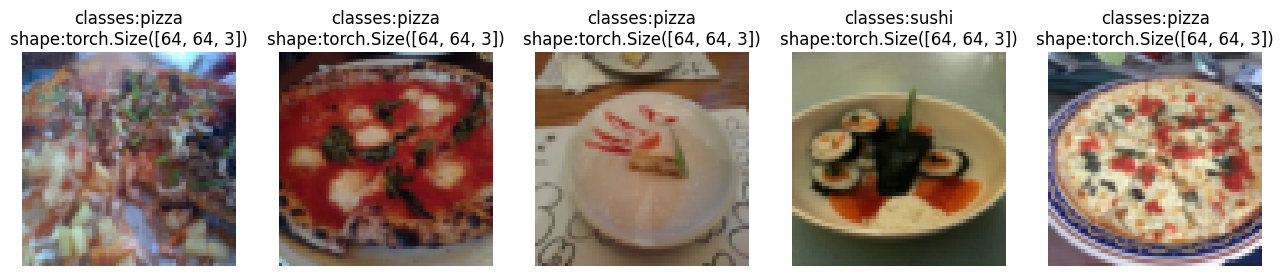

In [ ]:
display_random_images(train_data,
                      n = 5,
                      classes=class_names,
                      seed=None)

In [ ]:
# display_shape=True) → titles show both class name and the image shape (64, 64, 3).
# Bottom row (display_shape=False) → titles only show the class name
# k means pick the k no of random indecies
# random_samples_idx is just a list of random positions in the dataset that we’ll use in the next step to fetch and display random images.
#1 → 1 row (all images in one row).
#n → number of columns (equal to number of images you want to display).
#i+1 → position of the subplot (since Python loops start at i=0, we add +1 to start subplot positions from 1).
#Suppose n = 5 (5 images to display):

#plt.subplot(1, 5, 1) → 1 row, 5 columns, place plot at position 1.

#plt.subplot(1, 5, 2) → place plot at position 2.

#…

#plt.subplot(1, 5, 5) → place plot at position 5.

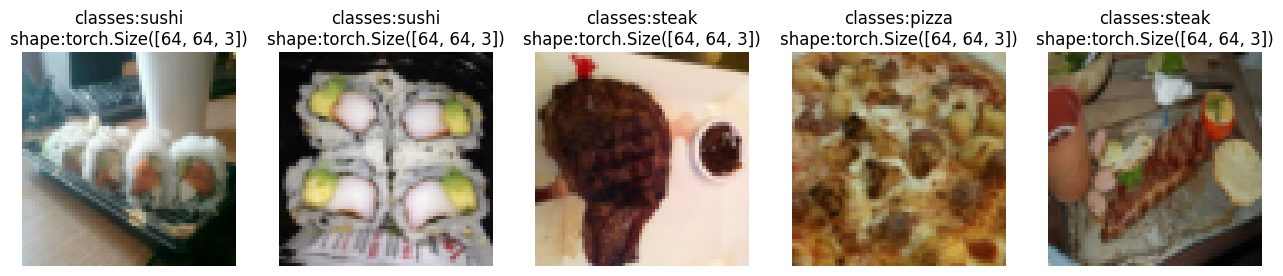

In [ ]:
#  Display random images from the ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=5,
                      classes = class_names)

## 5.4  Turn custom loaded images into `Dataloader`

In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset = train_data_custom,
                                     batch_size = BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)
test_dataloader_custom = DataLoader(dataset= test_data_custom,
                                    batch_size = BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)
train_dataloader_custom,test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7a5b4d6746e0>,
 <torch.utils.data.dataloader.DataLoader at 0x7a5b4d18c1d0>)

In [ ]:
# get image and label from custom dataloader
img_custom , label_custom = next(iter(train_dataloader_custom))

# print out shapes
img_custom.shape,label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
#The function iter() creates an iterator object from the dataloader.

#This tells Python: "I want to start pulling batches from this dataloader one by one."
# next() gives you the next batch from the iterator.

## 6. Other forms of transforms (data augmentations)

Data augmentations is the processof artificially adding diversity to your training data

in the case of image data, this may mean applying various image transformations to training images

Let's take a look at one particular type of data augmaentation used to train Pytorch vision models to states of the art levels

In [ ]:
from torchvision import transforms
train_transform = transforms.Compose([
                                        transforms.Resize(size=(224,224)),
                                        transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                        transforms.ToTensor()
])

test_transform = transforms.Compose([
                                    transforms.Resize(size=(224,224)),
                                    transforms.ToTensor()
])

In [ ]:
 # get all image path
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('/data/pizza_steak_sushi/train/pizza/1524655.jpg'),
 PosixPath('/data/pizza_steak_sushi/train/pizza/1008844.jpg'),
 PosixPath('/data/pizza_steak_sushi/train/pizza/1633289.jpg'),
 PosixPath('/data/pizza_steak_sushi/train/pizza/1412034.jpg'),
 PosixPath('/data/pizza_steak_sushi/train/pizza/218711.jpg'),
 PosixPath('/data/pizza_steak_sushi/train/pizza/244505.jpg'),
 PosixPath('/data/pizza_steak_sushi/train/pizza/765799.jpg'),
 PosixPath('/data/pizza_steak_sushi/train/pizza/68684.jpg'),
 PosixPath('/data/pizza_steak_sushi/train/pizza/3860002.jpg'),
 PosixPath('/data/pizza_steak_sushi/train/pizza/2493954.jpg')]

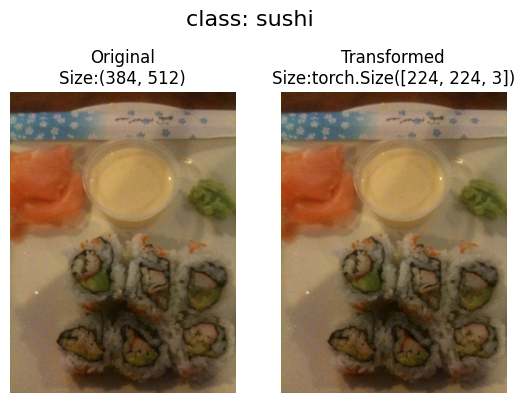

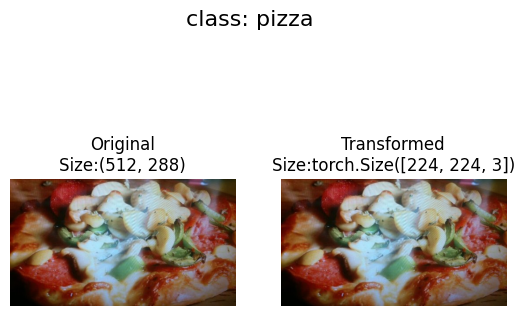

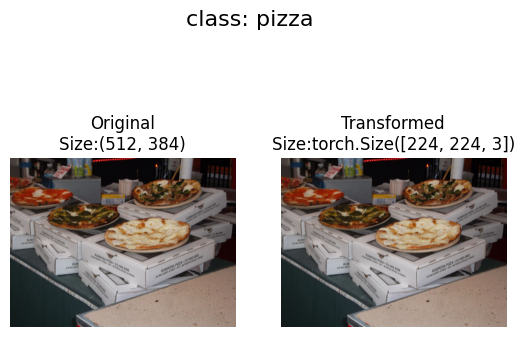

In [ ]:
# plot random images
plot_transformed_images(
    image_path = image_path_list,
    transform=train_transform,
    n=3,
    seed = None
)

## 7. Model 0: TinyVGG without data augmentation

### 7.1 Creating tranforms and loading data for model 0

In [ ]:
# create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [ ]:
# 1 .load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                       transform=simple_transform)

# 2 Turn dataset into data loader
import os
from torch.utils.data import DataLoader

# batch size
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# create dataloader
train_dataloader_simple = DataLoader(dataset = train_data_simple,
                                     batch_size= BATCH_SIZE,
                                     shuffle = True,
                                     num_workers = NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset = test_data_simple,
                                    batch_size = BATCH_SIZE,
                                    shuffle = False,
                                    num_workers = NUM_WORKERS)

### 7.2 create tinyvgg

In [ ]:
class TinyVGG(nn.Module):
  def __init__(self,input_shape:int,
               hidden_units:int,
               output_shape:int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self,x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))


In [ ]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try forward pass on the single images

In [ ]:
# get single image
image_batch,label_batch =next(iter(train_dataloader_simple))
image_batch.shape,label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9129e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6417e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7980e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1815e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3994e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.2317e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary
summary(model_0,input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Create train and test functions

* `train_step()` - takes in a model and dataloader and trains the model on the dataloader

* `test_step()` - takes in a model and dataloader and evaluate the model on the dataloader

In [ ]:
# train step
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
  # put the model in train mode

  model.train()

  # setup train loss and accuracy values
  train_loss,train_acc = 0,0

  # loop
  for batch,(x,y) in enumerate(dataloader):
    # send the data to target device
    x,y = x.to(device),y.to(device)

    # 1.forward pass
    y_pred = model(x)

    # 2 calculate the loss
    loss = loss_fn(y_pred,y)
    train_loss += loss

    # 3 Optimzer zero grad
    optimizer.zero_grad()

    # 4 loss backward
    loss.backward()

    # 5 optimizer step
    optimizer.step()

    # calculate the accuaracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # adjust metrics to get average loss and average acc per batch
  train_loss = train_loss/len(dataloader)
  train_acc = train_loss/len(dataloader)

  return train_loss,train_acc

In [ ]:
# create test step
def test_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              device=device):
  model.eval()

  # setup test loss and acc

  test_loss,test_acc = 0,0

  with torch.inference_mode():
    for batch ,(x,y) in enumerate(dataloader):
      # data target device
      x,y = x.to(device),y.to(device)

      # 1 forward pass
      test_pred_logits = model(x)

      # 2 calculate the loss
      loss = loss_fn(test_pred_logits,y)
      test_loss += loss.item()

      # cal acc
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y ).sum().item()/len(test_pred_labels))

    # acc and loss per batch
    test_loss /= len(dataloader)
    test_acc /=len(dataloader)

    return test_loss, test_acc

### 7.6 Creating `train()`

In [ ]:
from tqdm.auto import tqdm

# 1 create train function
def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          loss_fn:torch.nn.Module = nn.CrossEntropyLoss(),
          epochs:int=5,
          device=device):
  # 2 create empty results dict
  results = {"train_loss":[],
             "train_acc":[],
             "test_loss":[],
             "test_acc":[]}
  # 3 loop
  for epoch in tqdm(range(epochs)):
    train_loss,train_acc = train_step(model = model,
                                      dataloader = train_dataloader,
                                      loss_fn=loss_fn,
                                      optimizer=optimizer,
                                      device=device)
    test_loss,test_acc = test_step(model = model,
                                   dataloader=test_dataloader,
                                   loss_fn=loss_fn,
                                   device=device)

    # 4 . print
    print(f"Epochs:{epoch} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f}")

    # 5 update results
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # return
  return results

### 7.7 evalute the model 0

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# epochs
NUM_EPOCHS = 5

model_0= TinyVGG(input_shape=3,
                 hidden_units=10,
                 output_shape = len(train_data.classes)).to(device)

# loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(),
                             lr = 0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# train model_0

model_0_results = train(model = model_0,
                        train_dataloader = train_dataloader_simple,
                        test_dataloader = test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# end timer
end_time = timer()

print(f"total time {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epochs:0 | train_loss: 1.1063 | train_acc: 0.1383 | test_loss: 1.0983 | test_acc: 0.3011
Epochs:1 | train_loss: 1.0998 | train_acc: 0.1375 | test_loss: 1.0697 | test_acc: 0.5417
Epochs:2 | train_loss: 1.0869 | train_acc: 0.1359 | test_loss: 1.0809 | test_acc: 0.4924
Epochs:3 | train_loss: 1.0846 | train_acc: 0.1356 | test_loss: 1.0606 | test_acc: 0.5729
Epochs:4 | train_loss: 1.0662 | train_acc: 0.1333 | test_loss: 1.0658 | test_acc: 0.5644
total time 11.510 seconds


In [ ]:
model_0_results

{'train_loss': [tensor(1.1063, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0998, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0869, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0846, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0662, device='cuda:0', grad_fn=<DivBackward0>)],
 'train_acc': [tensor(0.1383, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.1375, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.1359, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.1356, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.1333, device='cuda:0', grad_fn=<DivBackward0>)],
 'test_loss': [1.0983202854792278,
  1.0697001218795776,
  1.0808685223261516,
  1.0605626503626506,
  1.065793514251709],
 'test_acc': [0.30113636363636365,
  0.5416666666666666,
  0.49242424242424243,
  0.5729166666666666,
  0.5643939393939394]}

### 7.8 loss curve

In [ ]:
# get the model results key
model_0_results.keys()


dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [ ]:
def plot_loss_curves(results:Dict[str,List[float]]):
  # get the loss values
  loss= torch.tensor(results["train_loss"]).cpu().numpy()
  test_loss = results["test_loss"]

  # get acc
  acc = torch.tensor(results["train_acc"]).cpu().numpy()
  test_acc = results["test_acc"]

  # get epochs
  epochs = range(len(results["train_loss"]))

  # plot
  plt.figure(figsize=(15,7))

  # plot subplot
  plt.subplot(1,2,1)
  plt.plot(epochs,loss,label="train_loss")
  plt.plot(epochs,test_loss,label="test_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # plot acc
  plt.subplot(1,2,2)
  plt.plot(epochs,acc,label="train_acc")
  plt.plot(epochs,test_acc,label="test_acc")
  plt.title("Accuracy")
  plt.xlabel("epochs")
  plt.legend()

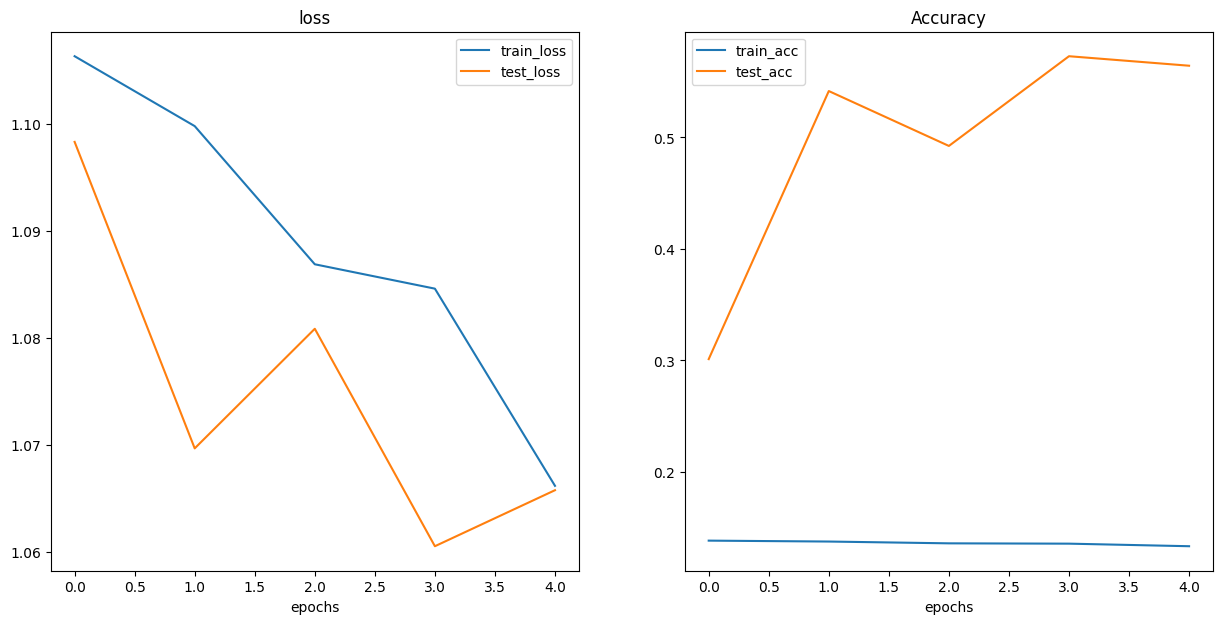

In [ ]:
plot_loss_curves(model_0_results)

## 8. ideal loss curvers


## 9. Model 1 : TinyVGG with Data Augmentation


### 9.1 Create transform with data augmentation

In [ ]:
# creating training transform with TriviailAugmentation
from torchvision import transforms

train_transform_trivial = transforms.Compose(
    [transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()]
)
test_transform_simple = transforms.Compose(
    [transforms.Resize(size=(64,64)),
    transforms.ToTensor()])

### 9.2 Create train and test Dataset and dataloader


In [ ]:
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple)

In [ ]:
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset = test_data_simple,
                                    batch_size = BATCH_SIZE,
                                    shuffle=False,
                                    num_workers = NUM_WORKERS)

### 9.3 construct and train model 1


In [ ]:
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape = len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS= 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_1.parameters(),
                             lr = 0.001)

from timeit import default_timer as timer
start_time = timer()

model_1_results = train(model=model_1,
                        train_dataloader = train_dataloader_augmented,
                        test_dataloader = test_dataloader_simple,
                        optimizer = optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

end_time = timer()
print(f"{end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epochs:0 | train_loss: 1.1049 | train_acc: 0.1381 | test_loss: 1.1019 | test_acc: 0.2604
Epochs:1 | train_loss: 1.0807 | train_acc: 0.1351 | test_loss: 1.1261 | test_acc: 0.2604
Epochs:2 | train_loss: 1.0712 | train_acc: 0.1339 | test_loss: 1.1592 | test_acc: 0.2604
Epochs:3 | train_loss: 1.1254 | train_acc: 0.1407 | test_loss: 1.1581 | test_acc: 0.2604
Epochs:4 | train_loss: 1.0858 | train_acc: 0.1357 | test_loss: 1.1551 | test_acc: 0.3333
12.449 seconds


In [ ]:
model_1_results

{'train_loss': [tensor(1.1049, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0807, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0712, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.1254, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0858, device='cuda:0', grad_fn=<DivBackward0>)],
 'train_acc': [tensor(0.1381, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.1351, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.1339, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.1407, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.1357, device='cuda:0', grad_fn=<DivBackward0>)],
 'test_loss': [1.1019273201624553,
  1.1260879834493,
  1.1592483123143513,
  1.1580922603607178,
  1.1551042397816975],
 'test_acc': [0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667,
  0.3333333333333333]}

### 9.4 loss curvers

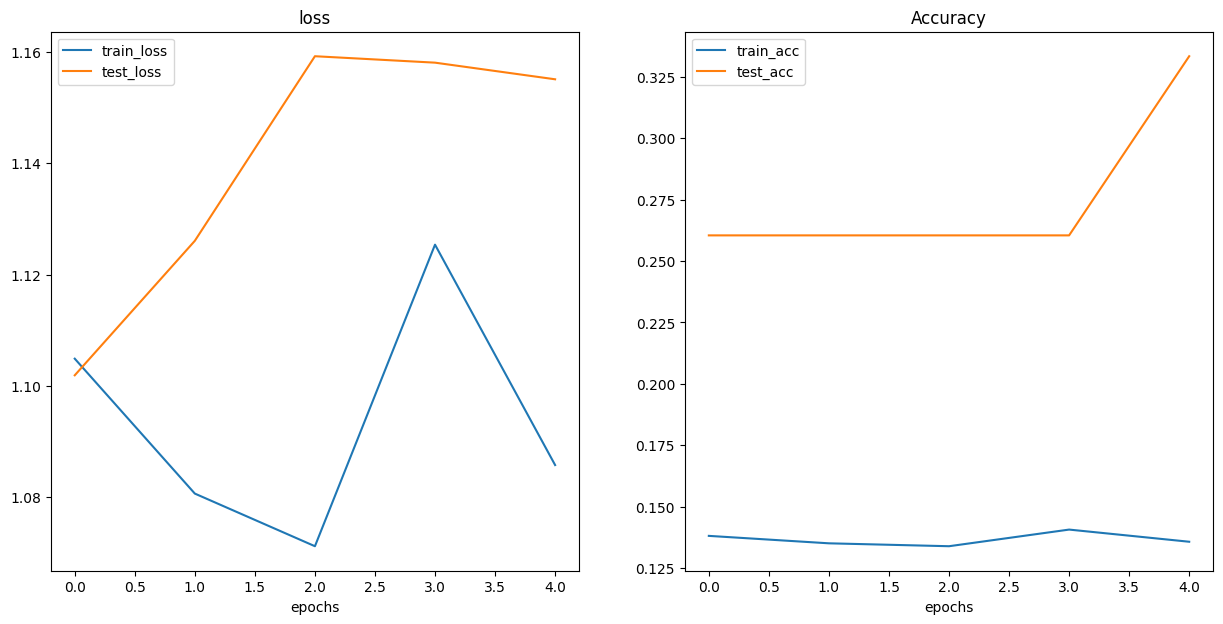

In [ ]:
plot_loss_curves(model_1_results)

## 10. Compare model results

After evaluating our modelling experiment on their own, it's important to compare them to each other

There's a few different ways to do this:
1. Hard coding (what we're doing)
2. Pytorch + tensorboard
3. weights and Biases
4. MLFlow


In [ ]:
import pandas as pd

# Convert all tensors to CPU + numpy (or Python scalars)
def tensor_to_value(x):
    if hasattr(x, "detach"):  # check if it's a tensor
        return x.detach().cpu().item() if x.numel() == 1 else x.detach().cpu().numpy()
    return x

# Apply conversion to results
model_0_clean = {k: [tensor_to_value(v) for v in vals] for k, vals in model_0_results.items()}
model_1_clean = {k: [tensor_to_value(v) for v in vals] for k, vals in model_1_results.items()}

# Now create DataFrames
model_0_df = pd.DataFrame(model_0_clean)
model_1_df = pd.DataFrame(model_1_clean)
model_0_df,model_1_df

(   train_loss  train_acc  test_loss  test_acc
 0    1.106320   0.138290   1.098320  0.301136
 1    1.099793   0.137474   1.069700  0.541667
 2    1.086891   0.135861   1.080869  0.492424
 3    1.084615   0.135577   1.060563  0.572917
 4    1.066203   0.133275   1.065794  0.564394,
    train_loss  train_acc  test_loss  test_acc
 0    1.104914   0.138114   1.101927  0.260417
 1    1.080679   0.135085   1.126088  0.260417
 2    1.071223   0.133903   1.159248  0.260417
 3    1.125395   0.140674   1.158092  0.260417
 4    1.085805   0.135726   1.155104  0.333333)

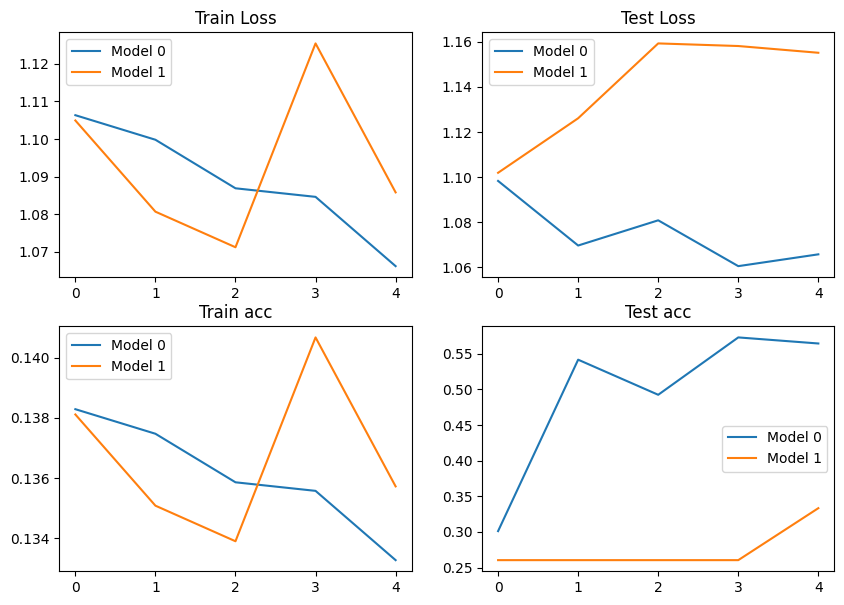

In [ ]:
# setup plot
plt.figure(figsize=(10,7))

# get the no of epochs
epochs = range(len(model_0_df))

# plot train loss
plt.subplot(2,2,1)
plt.plot(epochs,model_0_df["train_loss"],label="Model 0")
plt.plot(epochs,model_1_df["train_loss"],label="Model 1")
plt.title("Train Loss")
plt.legend()

# plot test loss
plt.subplot(2,2,2)
plt.plot(epochs,model_0_df["test_loss"],label="Model 0")
plt.plot(epochs,model_1_df["test_loss"],label="Model 1")
plt.title("Test Loss")
plt.legend()

# plot train acc
plt.subplot(2,2,3)
plt.plot(epochs,model_0_df["train_acc"],label="Model 0")
plt.plot(epochs,model_1_df["train_acc"],label="Model 1")
plt.title("Train acc")
plt.legend()

# plot train acc
plt.subplot(2,2,4)
plt.plot(epochs,model_0_df["test_acc"],label="Model 0")
plt.plot(epochs,model_1_df["test_acc"],label="Model 1")
plt.title("Test acc")
plt.legend()

## 11. Making prediction

In [ ]:
# Download custom  image
import requests

# setup custom image
custom_image_path = data_path/"04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path,"wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
    print(f"{custom_image_path} already download...")


/data/04-pizza-dad.jpeg already download...


### 11.1 Loading in a custom image with pytorch

* in tensor form with datatype torch.float32
* of shape 64X64X3
* on right device



In [ ]:
from PIL import Image
from torchvision import transforms

# Open with PIL (supports jpeg, png, bmp, tif, etc.)
img = Image.open(custom_image_path).convert("RGB")

# Convert to tensor (values in [0,1], shape [C,H,W])
img_tensor = transforms.ToTensor()(img)

print(img_tensor.shape, img_tensor.dtype)


torch.Size([3, 4032, 3024]) torch.float32


In [ ]:
import torchvision
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
print(f"Custom image tensor:\n{custom_image_uint8}")
print(f"custom image shape:{custom_image_uint8.shape}")
print(f"custom image dtype:{custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
custom image shape:torch.Size([3, 4032, 3024])
custom image dtype:

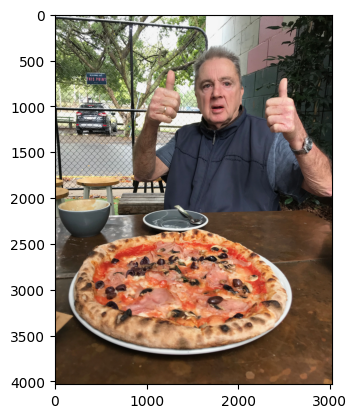

In [ ]:
plt.imshow(custom_image_uint8.permute(1,2,0))

### 11.2 Making a prediction on a custom image with a trained Pytorch model

In [ ]:
# # Try to make a prediction on an image in uint8 format
# model_1.eval()
# with torch.inference_mode():
#   model_1(custom_image_uint8.to(device))

In [ ]:
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)/255
custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

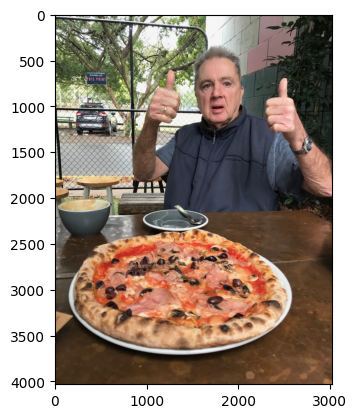

In [ ]:
plt.imshow(custom_image.permute(1,2,0))

In [ ]:
# create transform pipeline to resize the image
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64,64))

])
custom_image_transformed = custom_image_transform(custom_image)

# print
print(f"Custom image shape:{custom_image.shape}")
print(f"Transformed shape:{custom_image_transformed.shape}")

Custom image shape:torch.Size([3, 4032, 3024])
Transformed shape:torch.Size([3, 64, 64])


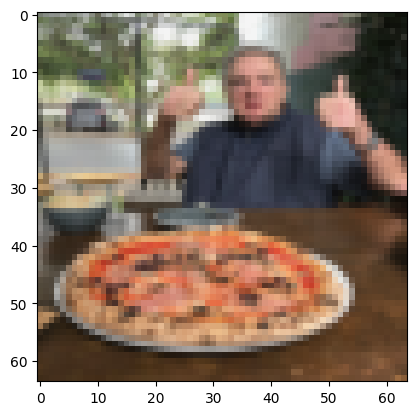

In [ ]:
plt.imshow(custom_image_transformed.permute(1,2,0))

In [ ]:
custom_image_transformed.shape,custom_image_transformed.unsqueeze(dim=0).shape

(torch.Size([3, 64, 64]), torch.Size([1, 3, 64, 64]))

In [ ]:
# this will error batch is not available
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))
custom_image_pred

tensor([[ 0.0795,  0.0361, -0.2083]], device='cuda:0')

make a prediction on a custom image we had to;
* Load the image and turn it into a tensor
* Make sure the image was the same datatype as the model (torch.float32)
* Make sure the image was the same shape as the data the model was trained on
(64X64X3) with batch size... (1,3,64,64)

* Make sure image is same device

In [ ]:
# Convert logits to prediction labels
custom_image_pred_probs = torch.softmax(custom_image_pred,dim=1)
custom_image_pred_probs

tensor([[0.3694, 0.3537, 0.2770]], device='cuda:0')

In [ ]:
# Convert prediction probabilities -> predicition labels
custom_image_pred_labels = torch.argmax(custom_image_pred_probs,dim=1).cpu()
custom_image_pred_labels

tensor([0])

In [ ]:
class_names[custom_image_pred_labels]

'pizza'

### 11.3 putting custom image prediction together: bulding a function

Ideal outcome:

A Function where we pass image path to and hava our model predict on that image
and plot the image + prediction.



In [ ]:
def pred_and_plot_image(model:torch.nn.Module,
                        image_path:str,
                        class_names:List[str] = None,
                        transform=None,
                        device=device):
  # load in the image
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # divide image pixel value by 255 to get [0,1]
  target_image /= 255.

  # transform
  if transform:
    target_image = transform(target_image)

  # Make sure the model is on the target device
  model.to(device)

  # turn model into inference_mode
  model.eval()
  with torch.inference_mode():
    # Add extra dim is batch dimestion
    target_image = target_image.unsqueeze(0)

    # make prediction
    target_image_pred = model(target_image.to(device))

  # convert the logits
  target_image_pred_probs = torch.softmax(target_image_pred,dim=1)

  # convert prediction prebability
  target_image_pred_labels = torch.argmax(target_image_pred_probs,dim=1)

  # plot the image
  plt.imshow(target_image.squeeze().permute(1,2,0))
  if class_names:
    title = f"Pred:{class_names[target_image_pred_labels.cpu()]} | Prob:{target_image_pred_probs.max().cpu():.3f}"
  else:
    title = f"Pred:{target_image_pred_labels.cpu()}  | Prob:{target_image_pred_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis("off")


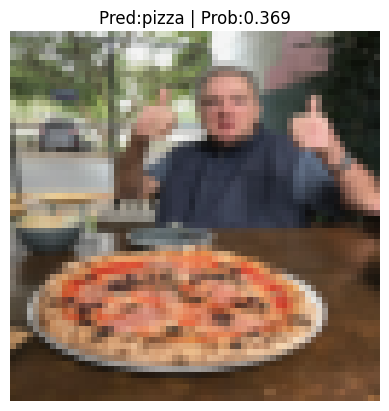

In [ ]:
# pred on the custom image
pred_and_plot_image(model=model_1,
                    image_path = custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)